In [26]:
import xarray as xr
import numpy as np

from matplotlib import pyplot as plt

from cartopy.feature import ShapelyFeature, OCEAN, LAKES, LAND
from cartopy.crs import PlateCarree
from cartopy.io.shapereader import Reader as ShapeReader, natural_earth

import geocat.datafiles as gdf
from geocat.viz import cmaps as gvcmaps
from geocat.viz import util as gvutil

In [39]:
ds_disk = xr.open_dataset('/media/sr0046/WD-exFAT-50/DATA/chirps/chirps-v2.0.2000.days_p05.nc').sel(time='2000-12-31T00:00:00.000000000')


In [38]:
ds_disk

<xarray.Dataset>
Dimensions:    (latitude: 2000, longitude: 7200)
Coordinates:
  * latitude   (latitude) float32 -49.975 -49.925 -49.875 ... 49.924995 49.975
  * longitude  (longitude) float32 -179.975 -179.925 ... 179.92499 179.975
    time       datetime64[ns] 2000-12-31
Data variables:
    precip     (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-11-20
    creator_name:      Pete Peterson
    creator_email:     pete@geog.ucsb.edu
    institution:       Climate Hazards Group.  University of California at Sa...
    documentation:     http://pubs.usgs.gov/ds/832/
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

In [49]:

# Download the Natural Earth shapefile for country boundaries at 10m resolution
shapefile = natural_earth(category='cultural',
                          resolution='10m',
                          name='admin_0_countries')

# Sort the geometries in the shapefile into Chinese/Taiwanese or other
country_geos = []
other_land_geos = []
for record in ShapeReader(shapefile).records():
    if record.attributes['ADMIN'] in ['Madagascar']:
        country_geos.append(record.geometry)
    else:
        other_land_geos.append(record.geometry)

# Define map projection to allow Cartopy to transform ``lat`` and ``lon`` values accurately into points on the
# matplotlib plot canvas.
projection = PlateCarree()

# Define a Cartopy Feature for the country borders and the land mask (i.e.,
# all other land) from the shapefile geometries, so they can be easily plotted
countries = ShapelyFeature(country_geos,
                           crs=projection,
                           facecolor='none',
                           edgecolor='black',
                           lw=1.5)
land_mask = ShapelyFeature(other_land_geos,
                           crs=projection,
                           facecolor='white',
                           edgecolor='none')

# Download the Natural Earth shapefile for the states/provinces at 10m resolution
shapefile = natural_earth(category='cultural',
                          resolution='10m',
                          name='admin_1_states_provinces')

# Extract the Chinese province borders
province_geos = [record.geometry for record in ShapeReader(shapefile).records()
                 if record.attributes['admin'] == 'Madagascar']


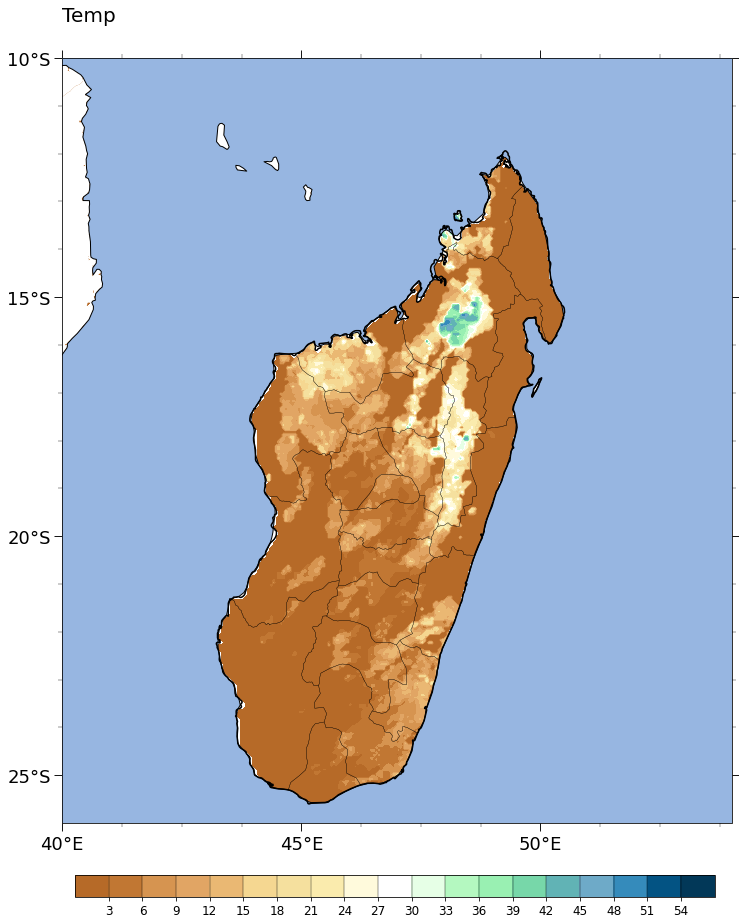

In [50]:
ds_disk = xr.open_dataset('/media/sr0046/WD-exFAT-50/DATA/chirps/chirps-v2.0.2000.days_p05.nc')
ds_disk = ds_disk.sel(time='2000-11-30T00:00:00.000000000')
lat = ds_disk["latitude"]
lon = ds_disk["longitude"]
precip = ds_disk["precip"]

ds = ds_disk


# Generate figure (set its size (width, height) in inches) and axes using Cartopy
fig = plt.figure(figsize=(12,15))
ax = plt.axes(projection=projection)

ax.set_extent([42, 54, -26, -11], crs=projection)

# Define the contour levels
clevs = np.arange(0, 60, 3, dtype=float)

# Import an NCL colormap, truncating it by using geocat.viz.util convenience function
newcmp = gvutil.truncate_colormap(gvcmaps.precip_diff_12lev, minval=0, maxval=1, n=len(clevs))

# Draw the temperature contour plot with the subselected colormap
# (Place the zorder of the contour plot at the lowest level)
cf = ax.contourf(lon, lat, precip, levels=clevs, cmap=newcmp, zorder=1)

# Draw horizontal color bar
cax = plt.axes((0.14, 0.08, 0.74, 0.02))
cbar = plt.colorbar(cf, ax=ax, cax=cax, ticks=clevs[1:-1], drawedges=True, orientation='horizontal')
cbar.ax.tick_params(labelsize=12)

# Add the land mask feature on top of the contour plot (higher zorder)
ax.add_feature(land_mask, zorder=2)

# Add the OCEAN and LAKES features on top of the contour plot
ax.add_feature(OCEAN.with_scale('50m'), edgecolor='black', lw=1, zorder=2)
ax.add_feature(LAKES.with_scale('50m'), edgecolor='black', lw=1, zorder=2)

# Add the country and province features (which are transparent) on top
ax.add_feature(countries, zorder=3)
ax.add_feature(provinces, zorder=3)

# Use geocat.viz.util convenience function to set axes tick values
gvutil.set_axes_limits_and_ticks(ax, xticks=[40, 45, 50], yticks=[-25, -20, -15, -10])

# Use geocat.viz.util convenience function to make plots look like NCL plots by using latitude, longitude tick labels
gvutil.add_lat_lon_ticklabels(ax)

# Use geocat.viz.util convenience function to add minor and major tick lines
gvutil.add_major_minor_ticks(ax, x_minor_per_major=4, y_minor_per_major=5, labelsize=18)

# Use geocat.viz.util convenience function to add main title as well as titles to left and right of the plot axes.
gvutil.set_titles_and_labels(ax, lefttitle="Temp", lefttitlefontsize=20)

# Show the plot
plt.show()

In [ ]:
# Create a data with the frequency of wet days (>1mm rainfall in one day)